In [1]:
import os
from glob import glob
from tqdm import tqdm
import cv2
import numpy as np
np.random.seed(2455)
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

import albumentations as A

## 이미지 Aug & Mix 복사

In [888]:
def save_img(path, img) :
    extension = ".png"#os.path.splitext(path)[1] # 이미지 확장자
    result, encoded_img = cv2.imencode(extension, img)
    
    if result:
        with open(path, mode='w+b') as f:
            encoded_img.tofile(f)

    
def load_img(path) :
    img_array = np.fromfile(path, np.uint8)
    img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
    return img
    # return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


In [3]:
path = './data/train/*'
label_dict = []
for p in glob(path):
    label_name = p.split("\\")[-1]
    label_cnt = len(glob(p+"/*"))
    label_dict.append([label_name, label_cnt])
    
label_dict = sorted(label_dict, key=lambda x:x[-1])
for k, v in label_dict :
    print(k + " : " + str(v))



반점 : 3
틈새과다 : 5
가구수정 : 12
녹오염 : 14
이음부불량 : 17
울음 : 22
창틀,문틀수정 : 27
피스 : 51
들뜸 : 54
석고수정 : 57
면불량 : 99
몰딩수정 : 130
오타공 : 142
곰팡이 : 145
터짐 : 162
꼬임 : 210
걸레받이수정 : 307
오염 : 595
훼손 : 1405


### 반점
#### 적용 리스트
- 회전, 뒤집기, 그리드스플릿, 색반전, Mixup

In [4]:
transforms = A.Compose([
    A.Rotate(p=1),
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
    ],p = 0.5),
    A.RandomGridShuffle(),
    A.ColorJitter(),
    A.RandomSunFlare(src_radius=200),
    A.ToGray(p=0.5),
    # A.ToSepia(),
    A.GridDistortion(),
    A.Perspective(p=1),
    # A.Spatter(intensity=0.3, p=1)
])

##### augmentations 180장

In [5]:
path = "./data/train/반점/*"
img_list = glob(path)

num_aug = 60
for idx, n in enumerate(tqdm(range(num_aug))) :
    for p in img_list :
        img = load_img(p)
        img = transforms(image=img)['image']
        
        save_path = os.path.join(p.split('\\')[-2], str(idx) + "_aug_" + p.split("\\")[-1])
        
        # cv2.imwrite(save_path, img)
        save_img(save_path, img)
        
        


100%|██████████| 60/60 [00:04<00:00, 12.69it/s]


##### mixup 162장
- 각 클래스에서 3장씩 샘플링

In [37]:
transforms = A.Compose([
    A.Rotate(p=1),
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
    ],p = 0.5),
    A.ColorJitter(),
])

In [38]:
path = './data/train/*'
curr_label = "반점"
num_sample = 3

folder_list = [p for p in glob(path) if curr_label not in p]
smapling_img_list = []
for idx, f in enumerate(folder_list) :
    img_list = glob(os.path.join(f, '*'))
    sampling = np.random.choice(len(img_list), num_sample, replace=False)
    smapling_img_list.extend(np.array(img_list)[sampling].tolist())

In [40]:
curr_img_list = [i for i in glob(os.path.join(path[:-1], curr_label, '*')) if "_" not in i]
for s_idx, sampling_img_path in enumerate(tqdm(smapling_img_list)) :
    for c_idx, curr_img_path in enumerate(curr_img_list) :
        samp_img = load_img(sampling_img_path)
        curr_img = transforms(image=load_img(curr_img_path))['image']
        
        samp_img = cv2.resize(samp_img, (600, 600))
        curr_img = cv2.resize(curr_img, (600, 600))
        
        img = cv2.addWeighted(curr_img, 0.85, samp_img, 0.15, 0)
        
        save_path = os.path.join(curr_img_path.split('\\')[-2], str(s_idx) + "_mix_" + curr_img_path.split("\\")[-1])
        
        save_img(save_path, img)

100%|██████████| 54/54 [00:04<00:00, 12.19it/s]


### 틈새과다
#### 적용 리스트
- 회전, 뒤집기, 그리드스플릿, 색반전, Mixup

In [245]:
aug_transforms = A.Compose([
    A.Rotate(p=1),
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
    ],p = 0.5),
    A.GlassBlur(),
    A.ColorJitter(),
    A.ChannelShuffle(),
    A.FancyPCA(p=0.1),
    A.ToGray(p=0.5),
    A.Emboss(),
    A.GridDistortion(),
    A.Perspective(p=1),
    A.RandomShadow(p=0.3),    
    A.RandomCrop(height=550, width=500, p=1)
])

mix_transforms = A.Compose([
    A.Rotate(p=1),
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
    ],p = 0.5),
    A.ColorJitter(),
])


##### augmentation 200장

In [254]:
path = "./data/train/틈새과다/*"
img_list = glob(path)

num_aug = 40
for idx, n in enumerate(tqdm(range(num_aug))) :
    for p in img_list:
    
        img = load_img(p)
        img = aug_transforms(image=img)['image']
        
        save_path = os.path.join(p.split('\\')[-2], str(idx) + "_aug_" + p.split("\\")[-1])
        
        # plt.imshow(img)
    
        save_img(save_path, img)
        
        


100%|██████████| 40/40 [00:11<00:00,  3.55it/s]


##### mixup 180장
- 각 클래스에서 2장씩 샘플링

In [258]:
path = './data/train/*'
curr_label = "틈새과다"
num_sample = 2

folder_list = [p for p in glob(path) if curr_label not in p]
smapling_img_list = []
for idx, f in enumerate(folder_list) :
    img_list = glob(os.path.join(f, '*'))
    sampling = np.random.choice(len(img_list), num_sample, replace=False)
    smapling_img_list.extend(np.array(img_list)[sampling].tolist())

In [259]:
curr_img_list = [i for i in glob(os.path.join(path[:-1], curr_label, '*')) if "_" not in i]
for s_idx, sampling_img_path in enumerate(tqdm(smapling_img_list)) :
    for c_idx, curr_img_path in enumerate(curr_img_list) :
        samp_img = load_img(sampling_img_path)
        curr_img = transforms(image=load_img(curr_img_path))['image']
        
        samp_img = cv2.resize(samp_img, (600, 600))
        curr_img = cv2.resize(curr_img, (600, 600))
        
        img = cv2.addWeighted(curr_img, 0.7, samp_img, 0.3, 0)
        
        save_path = os.path.join(curr_img_path.split('\\')[-2], str(s_idx) + "_mix_" + curr_img_path.split("\\")[-1])
        
        save_img(save_path, img)
        

100%|██████████| 36/36 [00:05<00:00,  7.12it/s]


### 가구수정 
#### 적용 리스트
- 회전, 뒤집기, 그리드스플릿, 색반전, Mixup

In [567]:
aug_transforms = A.Compose([
    A.Resize(600, 600, p=1),
    A.Rotate(p=1),
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
    ],p = 0.5),
    # A.GlassBlur(),
    # A.ColorJitter(),
    # A.ChannelShuffle(),
    # A.FancyPCA(p=0.1),
    # A.ToGray(p=0.5),
    A.RandomBrightnessContrast(brightness_by_max=False,p=1),
    # A.GridDistortion(),
    A.Perspective(p=1),
    A.RandomShadow(p=0.3),    
    A.RandomCrop(height=550, width=500, p=1)
])

mix_transforms = A.Compose([
    A.Rotate(p=1),
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
    ],p = 0.5),
    A.ColorJitter(),
])


##### augmentation 120장
- 각 클래스에서 3장씩 샘플링

100%|██████████| 10/10 [00:02<00:00,  4.11it/s]


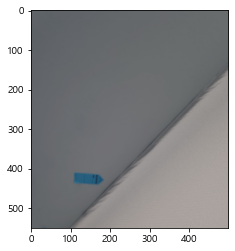

In [569]:
path = "./data/train/가구수정/*"
img_list = glob(path)

num_aug = 10
for idx, n in enumerate(tqdm(range(num_aug))) :
    for p in img_list:
    
        img = load_img(p)
        img = aug_transforms(image=img)['image']
        
        save_path = os.path.join(p.split('\\')[-2], str(idx) + "_aug_" + p.split("\\")[-1])
        
        plt.imshow(img)
    #     break
    # break
        save_img(save_path, img)
        
        


##### mixup 216장
- 각 클래스에서 1장씩 샘플링

In [572]:
path = './data/train/*'
curr_label = "가구수정"
num_sample = 1

folder_list = [p for p in glob(path) if curr_label not in p]
smapling_img_list = []
for idx, f in enumerate(folder_list) :
    img_list = glob(os.path.join(f, '*'))
    sampling = np.random.choice(len(img_list), num_sample, replace=False)
    smapling_img_list.extend(np.array(img_list)[sampling].tolist())
    
curr_img_list = [i for i in glob(os.path.join(path[:-1], curr_label, '*')) if "_" not in i]
for s_idx, sampling_img_path in enumerate(tqdm(smapling_img_list)) :
    for c_idx, curr_img_path in enumerate(curr_img_list) :
        samp_img = load_img(sampling_img_path)
        curr_img = transforms(image=load_img(curr_img_path))['image']
        
        samp_img = cv2.resize(samp_img, (600, 600))
        curr_img = cv2.resize(curr_img, (600, 600))
        
        img = cv2.addWeighted(curr_img, 0.8, samp_img, 0.2, 0)
        
        save_path = os.path.join(curr_img_path.split('\\')[-2], str(s_idx) + "_mix_" + curr_img_path.split("\\")[-1])
        
        save_img(save_path, img)
        

100%|██████████| 18/18 [00:05<00:00,  3.24it/s]


### 녹오염 
#### 적용 리스트
- 회전, 뒤집기, 그리드스플릿, 색반전, Mixup

In [894]:
aug_transforms = A.Compose([
    A.Resize(600, 600, p=1),
    A.Rotate(p=1),
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
    ],p = 0.5),
    A.GlassBlur(),
    # A.ColorJitter(),
    # A.ChannelShuffle(),
    A.RandomGridShuffle((2,2), p=1),
    # A.ToGray(p=0.5),
    # A.RandomBrightnessContrast(brightness_by_max=False,p=1),
    # A.GridDistortion(p=1),
    A.Perspective(p=1),
    A.RandomShadow(p=0.3),    
    A.RandomCrop(height=570, width=570, p=1)
])

mix_transforms = A.Compose([
    A.Rotate(p=1),
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
    ],p = 0.5),
    # A.ColorJitter(),
])


##### mixup 112장

100%|██████████| 8/8 [00:06<00:00,  1.33it/s]


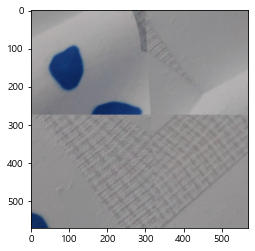

In [889]:
path = "./data/train/녹오염/*"
img_list = glob(path)

num_aug = 8
for idx, n in enumerate(tqdm(range(num_aug))) :
    for p in img_list:
    
        img = load_img(p)
        img = aug_transforms(image=img)['image']
        
        save_path = os.path.join(p.split('\\')[-2], str(idx) + "_aug_" + p.split("\\")[-1])
        
        # plt.imshow(img)
    #     break
    # break
        save_img(save_path, img)
        
        


##### augmentations 252장
- 각 클래스에서 3장씩 샘플링

In [896]:
path = './data/train/*'
curr_label = "녹오염"
num_sample = 1

folder_list = [p for p in glob(path) if curr_label not in p]
smapling_img_list = []
for idx, f in enumerate(folder_list) :
    img_list = glob(os.path.join(f, '*'))
    sampling = np.random.choice(len(img_list), num_sample, replace=False)
    smapling_img_list.extend(np.array(img_list)[sampling].tolist())
    
curr_img_list = [i for i in glob(os.path.join(path[:-1], curr_label, '*')) if "_" not in i]
for s_idx, sampling_img_path in enumerate(tqdm(smapling_img_list)) :
    for c_idx, curr_img_path in enumerate(curr_img_list) :
        samp_img = load_img(sampling_img_path)
        curr_img = mix_transforms(image=load_img(curr_img_path))['image']
        
        samp_img = cv2.resize(samp_img, (600, 600))
        curr_img = cv2.resize(curr_img, (600, 600))
        
        img = cv2.addWeighted(curr_img, 0.7, samp_img, 0.3, 0)
        
        save_path = os.path.join(curr_img_path.split('\\')[-2], str(s_idx) + "_mix_" + curr_img_path.split("\\")[-1])
        
        save_img(save_path, img)
        

100%|██████████| 18/18 [00:06<00:00,  2.79it/s]


### 이음부불량 
#### 적용 리스트
- 회전, 뒤집기, 그리드스플릿, 색반전, Mixup

In [982]:
aug_transforms = A.Compose([
    A.Resize(600, 600, p=1),
    A.Rotate(p=1),
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
    ],p = 0.5),
    # A.GlassBlur(),
    A.ColorJitter(),
    A.ChannelShuffle(),
    # A.RandomGridShuffle((2,2), p=1),
    A.ToGray(p=0.5),
    A.ToSepia(p=0.5),
    A.RandomBrightnessContrast(brightness_by_max=False,p=1),
    # A.GridDistortion(p=1),
    A.Perspective(p=1),
    # A.RandomShadow(p=0.3),    
    A.RandomCrop(height=570, width=570, p=1),
    A.Posterize(p=1)
])

mix_transforms = A.Compose([
    A.Rotate(p=1),
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
    ],p = 0.5),
    # A.ColorJitter(),
    A.Posterize(p=1),

])



##### mixup 162장m
- 각 클래스에서 3장씩 샘플링

In [981]:
path = "./data/train/이음부불량/*"
img_list = glob(path)

num_aug = 10
for idx, n in enumerate(tqdm(range(num_aug))) :
    for p in img_list[1:]:
    
        img = load_img(p)
        img = aug_transforms(image=img)['image']
        
        save_path = os.path.join(p.split('\\')[-2], str(idx) + "_aug_" + p.split("\\")[-1])
        
    #     plt.imshow(img)
    #     break
    # break
        save_img(save_path, img)
        
        


100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


##### augmentaitons 306장
- 각 클래스에서 1장씩 샘플링

In [984]:
path = './data/train/*'
curr_label = "이음부불량"
num_sample = 1

folder_list = [p for p in glob(path) if curr_label not in p]
smapling_img_list = []
for idx, f in enumerate(folder_list) :
    img_list = glob(os.path.join(f, '*'))
    sampling = np.random.choice(len(img_list), num_sample, replace=False)
    smapling_img_list.extend(np.array(img_list)[sampling].tolist())
    
curr_img_list = [i for i in glob(os.path.join(path[:-1], curr_label, '*')) if "_" not in i]
for s_idx, sampling_img_path in enumerate(tqdm(smapling_img_list)) :
    for c_idx, curr_img_path in enumerate(curr_img_list) :
        samp_img = load_img(sampling_img_path)
        curr_img = mix_transforms(image=load_img(curr_img_path))['image']
        
        samp_img = cv2.resize(samp_img, (600, 600))
        curr_img = cv2.resize(curr_img, (600, 600))
        
        img = cv2.addWeighted(curr_img, 0.8, samp_img, 0.2, 0)
        
        save_path = os.path.join(curr_img_path.split('\\')[-2], str(s_idx) + "_mix_" + curr_img_path.split("\\")[-1])
        
        save_img(save_path, img)
        

100%|██████████| 18/18 [00:07<00:00,  2.36it/s]


### 울음
#### 적용 리스트
- 회전, 뒤집기, 그리드스플릿, 색반전, Mixup

In [1212]:
aug_transforms = A.Compose([
    A.Resize(600, 600, p=1),
    A.Rotate(p=1),
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
    ],p = 0.5),
    # A.GlassBlur(),
    A.ColorJitter(),
    A.ChannelShuffle(),
    # A.RandomGridShuffle((2,2), p=1),
    A.ToGray(p=0.5),
    A.ToSepia(p=0.5),
    A.RandomBrightnessContrast(brightness_by_max=False,p=1),
    # A.GridDistortion(p=1),
    A.Perspective(p=1),
    # A.RandomShadow(p=0.3),    
    A.Equalize(by_channels=False,p=0.3),
    # A.RGBShift(p=1),
    A.RandomCrop(height=570, width=570, p=1),
    A.Posterize(num_bits=8, p=1),
])

mix_transforms = A.Compose([
    A.Rotate(p=1),
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
    ],p = 0.5),
    # A.ColorJitter(),
    A.Posterize(p=1),

])



##### mixup 220장
- 각 클래스에서 3장씩 샘플링

In [1214]:
path = "./data/train/울음/*"
img_list = glob(path)

num_aug = 10
for idx, n in enumerate(tqdm(range(num_aug))) :
    for p in img_list:
    
        img = load_img(p)
        img = aug_transforms(image=img)['image']
        
        save_path = os.path.join(p.split('\\')[-2], str(idx) + "_aug_" + p.split("\\")[-1])
        
    #     plt.imshow(img)
    #     break
    # break
        save_img(save_path, img)
        
        


100%|██████████| 10/10 [00:05<00:00,  1.95it/s]


##### augmentations 220장
- 각 클래스에서 3장씩 샘플링

In [1224]:
path = './data/train/*'
curr_label = "울음"
num_sample = 1

folder_list = [p for p in glob(path) if curr_label not in p]
smapling_img_list = []
for idx, f in enumerate(folder_list) :
    if np.random.binomial(n=1, p=0.5, size=1)[0] :
        img_list = glob(os.path.join(f, '*'))
        sampling = np.random.choice(len(img_list), num_sample, replace=False)
        smapling_img_list.extend(np.array(img_list)[sampling].tolist())
    
curr_img_list = [i for i in glob(os.path.join(path[:-1], curr_label, '*')) if "_" not in i]
for s_idx, sampling_img_path in enumerate(tqdm(smapling_img_list)) :
    for c_idx, curr_img_path in enumerate(curr_img_list) :
        samp_img = load_img(sampling_img_path)
        curr_img = mix_transforms(image=load_img(curr_img_path))['image']
        
        samp_img = cv2.resize(samp_img, (600, 600))
        curr_img = cv2.resize(curr_img, (600, 600))
        
        img = cv2.addWeighted(curr_img, 0.85, samp_img, 0.15, 0)
        
        save_path = os.path.join(curr_img_path.split('\\')[-2], str(s_idx) + "_mix_" + curr_img_path.split("\\")[-1])
        
        save_img(save_path, img)
        

100%|██████████| 10/10 [00:05<00:00,  1.87it/s]


### 창틀,문틀수정
#### 적용 리스트
- 회전, 뒤집기, 그리드스플릿, 색반전, Mixup

In [1291]:
aug_transforms = A.Compose([
    A.Resize(600, 600, p=1),
    A.Rotate(p=1),
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
    ],p = 0.5),
    A.Blur(),
    A.ColorJitter(),
    # A.ChannelShuffle(),
    # A.RandomGridShuffle((2,2), p=1),
    # A.ToGray(p=0.5),
    A.ToSepia(p=0.5),
    A.RandomBrightnessContrast(brightness_by_max=False,p=1),
    A.GridDistortion(p=0.5),
    A.Perspective(p=1),
    # A.RandomShadow(p=0.3),    
    # A.Equalize(by_channels=False,p=0.3),
    # A.RGBShift(p=1),
    A.RandomCrop(height=570, width=570, p=1),
    A.Posterize(num_bits=8, p=1),
])

mix_transforms = A.Compose([
    A.Rotate(p=1),
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
    ],p = 0.5),
    # A.ColorJitter(),
    A.Posterize(p=1),

])



##### mixup 210장
- 각 클래스에서 3장씩 샘플링

In [1295]:
path = "./data/train/창틀,문틀수정/*"
img_list = glob(path)

num_aug = 15
for idx, n in enumerate(tqdm(range(num_aug))) :
    for p in img_list[13:]:
    
        img = load_img(p)
        img = aug_transforms(image=img)['image']
        
        save_path = os.path.join(p.split('\\')[-2], str(idx) + "_aug_" + p.split("\\")[-1])
        
    #     plt.imshow(img)
    #     break
    # break
        save_img(save_path, img)
        
        


100%|██████████| 15/15 [00:04<00:00,  3.08it/s]


### 피스
#### 적용 리스트
- 회전, 뒤집기, 그리드스플릿, 색반전, Mixup

In [1407]:
aug_transforms = A.Compose([
    A.Resize(600, 600, p=1),
    A.Rotate(p=1),
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
    ],p = 0.5),
    # A.Blur(),
    A.ColorJitter(),
    A.ChannelShuffle(),
    # A.RandomGridShuffle((2,2), p=1),
    A.ToGray(p=0.5),
    A.ToSepia(p=0.5),
    A.RandomBrightnessContrast(brightness_by_max=False,p=1),
    # A.GridDistortion(p=0.5),
    A.Perspective(p=1),
    # A.RandomShadow(p=0.3),    
    A.Equalize(by_channels=False,p=0.3),
    # A.RGBShift(p=1),
    # A.RandomCrop(height=570, width=570, p=1),
    A.Posterize(num_bits=8, p=1),
])

mix_transforms = A.Compose([
    A.Rotate(p=1),
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
    ],p = 0.5),
    # A.ColorJitter(),
    A.Posterize(p=1),

])



##### mixup 255 장
- 각 클래스에서 3장씩 샘플링

In [1451]:
path = "./data/train/피스/*"
img_list = glob(path)

num_aug = 5
for idx, n in enumerate(tqdm(range(num_aug))) :
    for p in img_list:
    
        img = load_img(p)
        img = aug_transforms(image=img)['image']
        
        save_path = os.path.join(p.split('\\')[-2], str(idx) + "_aug_" + p.split("\\")[-1])
        
    #     plt.imshow(img)
    #     break
    # break
        save_img(save_path, img)
        
        


100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


### 들뜸
#### 적용 리스트
- 회전, 뒤집기, 그리드스플릿, 색반전, Mixup

In [1535]:
aug_transforms = A.Compose([
    A.Resize(600, 600, p=1),
    A.Rotate(p=1),
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
    ],p = 0.5),
    A.Blur(),
    A.ColorJitter(),
    A.ChannelShuffle(),
    # A.RandomGridShuffle((2,2), p=1),
    A.ToGray(p=0.5),
    A.ToSepia(p=0.5),
    A.RandomBrightnessContrast(brightness_by_max=False,p=1),
    # A.GridDistortion(p=0.5),
    A.Perspective(p=1),
    # A.RandomShadow(p=0.3),    
    # A.Equalize(by_channels=False,p=0.3),
    # A.RGBShift(p=1),
    # A.RandomCrop(height=570, width=570, p=1),
    A.Posterize(num_bits=8, p=1),
])

mix_transforms = A.Compose([
    A.Rotate(p=1),
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
    ],p = 0.5),
    # A.ColorJitter(),
    A.Posterize(p=1),

])



##### mixup 270 장
- 각 클래스에서 3장씩 샘플링

In [1536]:
path = "./data/train/들뜸/*"
img_list = glob(path)

num_aug = 5
for idx, n in enumerate(tqdm(range(num_aug))) :
    for p in img_list:
    
        img = load_img(p)
        img = aug_transforms(image=img)['image']
        
        save_path = os.path.join(p.split('\\')[-2], str(idx) + "_aug_" + p.split("\\")[-1])
        
    #     plt.imshow(img)
    #     break
    # break
        save_img(save_path, img)
        
        


100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


### 석고수정
#### 적용 리스트
- 회전, 뒤집기, 그리드스플릿, 색반전, Mixup

In [1687]:
aug_transforms = A.Compose([
    A.Resize(600, 600, p=1),
    A.Rotate(p=1),
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
    ],p = 0.5),
    A.Blur(),
    
    A.ColorJitter(),
    # A.ChannelShuffle(),
    A.OneOf([
        A.ToGray(p=0.5),
        A.ToSepia(p=0.5)
    ],p=0.5),
    # A.RandomGridShuffle((2,2), p=0.5),
    A.RandomBrightnessContrast(brightness_by_max=False,p=1),
    A.GridDistortion(p=1),
    A.Perspective(p=1),
    # A.RandomShadow(p=0.5),    
    # A.Equalize(by_channels=False,p=0.3),
    # A.RGBShift(p=1),
    # A.RandomCrop(height=570, width=570, p=1),
    A.Posterize(num_bits=8, p=1),
])

mix_transforms = A.Compose([
    A.Rotate(p=1),
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
    ],p = 0.5),
    # A.ColorJitter(),
    A.Posterize(p=1),

])



##### mixup 285장
- 각 클래스에서 3장씩 샘플링b

In [1688]:
path = "./data/train/석고수정/*"
img_list = glob(path)

num_aug = 5
for idx, n in enumerate(tqdm(range(num_aug))) :
    for p in img_list:
    
        img = load_img(p)
        img = aug_transforms(image=img)['image']
        
        save_path = os.path.join(p.split('\\')[-2], str(idx) + "_aug_" + p.split("\\")[-1])
        
    #     plt.imshow(img)
    #     break
    # break
        save_img(save_path, img)
        
        


100%|██████████| 5/5 [00:06<00:00,  1.38s/it]


### 면불량
#### 적용 리스트
- 회전, 뒤집기, 그리드스플릿, 색반전, Mixup

In [1698]:
aug_transforms = A.Compose([
    A.Resize(600, 600, p=1),
    A.Rotate(p=1),
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
    ],p = 0.5),
    A.Blur(),
    
    # A.ColorJitter(),
    # A.ChannelShuffle(),
    A.OneOf([
        A.ToGray(p=0.5),
        A.ToSepia(p=0.5)
    ],p=0.5),
    # A.RandomGridShuffle((2,2), p=0.5),
    A.RandomBrightnessContrast(brightness_by_max=False,p=1),
    A.GridDistortion(p=1),
    A.Perspective(p=1),
    # A.RandomShadow(p=0.5),    
    A.Equalize(by_channels=False,p=1),
    # A.RGBShift(p=1),
    # A.RandomCrop(height=570, width=570, p=1),
    A.Posterize(num_bits=8, p=1),
])

mix_transforms = A.Compose([
    A.Rotate(p=1),
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
    ],p = 0.5),
    # A.ColorJitter(),
    A.Posterize(p=1),

])



##### mixup 198장
- 각 클래스에서 3장씩 샘플링

In [1747]:
path = "./data/train/면불량/*"
img_list = glob(path)

num_aug = 2
for idx, n in enumerate(tqdm(range(num_aug))) :
    for p in img_list:
    
        img = load_img(p)
        img = aug_transforms(image=img)['image']
        
        save_path = os.path.join(p.split('\\')[-2], str(idx) + "_aug_" + p.split("\\")[-1])
        
    #     plt.imshow(img)
    #     break
    # break
        save_img(save_path, img)
        
        


100%|██████████| 2/2 [00:05<00:00,  2.62s/it]


### 몰딩수정
#### 적용 리스트
- 회전, 뒤집기, 그리드스플릿, 색반전, Mixup

In [1760]:
aug_transforms = A.Compose([
    A.Resize(600, 600, p=1),
    A.Rotate(p=1),
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
    ],p = 0.5),
    A.Blur(),
    
    A.ColorJitter(),
    # A.ChannelShuffle(),
    # A.OneOf([
    #     A.ToGray(p=0.5),
    #     A.ToSepia(p=0.5)
    # ],p=0.5),
    # A.RandomGridShuffle((2,2), p=0.5),
    A.RandomBrightnessContrast(brightness_by_max=False,p=1),
    A.GridDistortion(p=1),
    A.Perspective(p=1),
    A.RandomShadow(p=0.5),    
    # A.Equalize(by_channels=False,p=1),
    # A.RGBShift(p=1),
    A.RandomCrop(height=570, width=570, p=1),
    A.Posterize(num_bits=8, p=1),
])

mix_transforms = A.Compose([
    A.Rotate(p=1),
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
    ],p = 0.5),
    # A.ColorJitter(),
    A.Posterize(p=1),

])



##### mixup 130장
- 각 클래스에서 3장씩 샘플링

In [1796]:
path = "./data/train/몰딩수정/*"
img_list = glob(path)

num_aug = 1
for idx, n in enumerate(tqdm(range(num_aug))) :
    for p in img_list:
    
        img = load_img(p)
        img = aug_transforms(image=img)['image']
        
        save_path = os.path.join(p.split('\\')[-2], str(idx) + "_aug_" + p.split("\\")[-1])
        
    #     plt.imshow(img)
    #     break
    # break
        save_img(save_path, img)
        
        


100%|██████████| 1/1 [00:03<00:00,  3.11s/it]


### 오타공
#### 적용 리스트
- 회전, 뒤집기, 그리드스플릿, 색반전, Mixup

In [1840]:
aug_transforms = A.Compose([
    A.Resize(600, 600, p=1),
    A.Rotate(p=1),
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
    ],p = 0.5),
    A.Blur(),
    
    A.ColorJitter(),
    A.ChannelShuffle(),
    A.OneOf([
        A.ToGray(p=0.5),
        A.ToSepia(p=0.5)
    ],p=0.5),
    # A.RandomGridShuffle((2,2), p=0.5),
    A.RandomBrightnessContrast(brightness_by_max=False,p=1),
    A.GridDistortion(p=1),
    A.Perspective(p=1),
    # A.RandomShadow(p=0.5),    
    # A.Equalize(by_channels=False,p=1),
    # A.RGBShift(p=1),
    A.RandomCrop(height=570, width=570, p=1),
    A.Posterize(num_bits=8, p=1),
    A.PiecewiseAffine(p=1)
])

mix_transforms = A.Compose([
    A.Rotate(p=1),
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
    ],p = 0.5),
    # A.ColorJitter(),
    A.Posterize(p=1),

])



##### mixup 126장
- 각 클래스에서 3장씩 샘플링

In [1853]:
path = "./data/train/오타공/*"
img_list = glob(path)

num_aug = 1
for idx, n in enumerate(tqdm(range(num_aug))) :
    for p in img_list[16:]:
    
        img = load_img(p)
        img = aug_transforms(image=img)['image']
        
        save_path = os.path.join(p.split('\\')[-2], str(idx) + "_aug_" + p.split("\\")[-1])
        
    #     plt.imshow(img)
    #     break
    # break
        save_img(save_path, img)
        
        


100%|██████████| 1/1 [00:23<00:00, 23.93s/it]


### 곰팡이
#### 적용 리스트
- 회전, 뒤집기, 그리드스플릿, 색반전, Mixup

In [1894]:
aug_transforms = A.Compose([
    A.Resize(600, 600, p=1),
    A.Rotate(p=1),
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
    ],p = 0.5),
    # A.Blur(),
    
    # A.ColorJitter(),
    A.ChannelShuffle(),
    # A.OneOf([
        # A.ToGray(p=1),
        # A.ToSepia(p=0.5)
    # ],p=0.5),
    # A.RandomGridShuffle((2,2), p=0.5),
    A.RandomBrightnessContrast(brightness_by_max=False,p=1),
    A.GridDistortion(p=1),
    A.Perspective(p=1),
    # A.RandomShadow(p=0.5),    
    # A.Equalize(by_channels=False,p=1),
    # A.RGBShift(p=1),
    A.RandomCrop(height=570, width=570, p=1),
    A.Posterize(num_bits=8, p=1),
    # A.PiecewiseAffine(p=1)
])

mix_transforms = A.Compose([
    A.Rotate(p=1),
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
    ],p = 0.5),
    # A.ColorJitter(),
    A.Posterize(p=1),

])



##### mixup 145장
- 각 클래스에서 3장씩 샘플링

In [1914]:
path = "./data/train/곰팡이/*"
img_list = glob(path)

num_aug = 1
for idx, n in enumerate(tqdm(range(num_aug))) :
    for p in img_list:
    
        img = load_img(p)
        img = aug_transforms(image=img)['image']
        
        save_path = os.path.join(p.split('\\')[-2], str(idx) + "_aug_" + p.split("\\")[-1])
        
    #     plt.imshow(img)
    #     break
    # break
        save_img(save_path, img)
        
        


100%|██████████| 1/1 [00:03<00:00,  3.47s/it]


### 터짐
#### 적용 리스트
- 회전, 뒤집기, 그리드스플릿, 색반전, Mixup

In [1947]:
aug_transforms = A.Compose([
    A.Resize(600, 600, p=1),
    A.Rotate(p=1),
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
    ],p = 0.5),
    # A.Blur(),
    
    # A.ColorJitter(),
    A.ChannelShuffle(),
    # A.OneOf([
        # A.ToGray(p=1),
        # A.ToSepia(p=0.5)
    # ],p=0.5),
    # A.RandomGridShuffle((2,2), p=0.5),
    A.RandomBrightnessContrast(brightness_by_max=False,p=1),
    A.GridDistortion(p=1),
    A.Perspective(p=1),
    # A.RandomShadow(p=0.5),    
    A.Equalize(by_channels=False,p=1),
    # A.RGBShift(p=1),
    A.RandomCrop(height=570, width=570, p=1),
    A.Posterize(num_bits=8, p=1),
    # A.PiecewiseAffine(p=1)
])

mix_transforms = A.Compose([
    A.Rotate(p=1),
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
    ],p = 0.5),
    # A.ColorJitter(),
    A.Posterize(p=1),

])



##### mixup 162장
- 각 클래스에서 3장씩 샘플링

In [1949]:
path = "./data/train/터짐/*"
img_list = glob(path)

num_aug = 1
for idx, n in enumerate(tqdm(range(num_aug))) :
    for p in img_list:
    
        img = load_img(p)
        img = aug_transforms(image=img)['image']
        
        save_path = os.path.join(p.split('\\')[-2], str(idx) + "_aug_" + p.split("\\")[-1])
        
    #     plt.imshow(img)
    #     break
    # break
        save_img(save_path, img)
        
        


100%|██████████| 1/1 [00:04<00:00,  4.17s/it]


### Aug 적용 후 데이터 개수

In [1950]:
path = './data/train/*'
glob(path)
label_dict = []
for p in glob(path):
    label_name = p.split("\\")[-1]
    label_cnt = len(glob(p+"/*"))
    label_dict.append([label_name, label_cnt])
    
label_dict = sorted(label_dict, key=lambda x:x[-1])
for k, v in label_dict :
    print(k + " : " + str(v))



꼬임 : 210
창틀,문틀수정 : 237
몰딩수정 : 260
오타공 : 268
곰팡이 : 290
면불량 : 297
피스 : 306
걸레받이수정 : 307
들뜸 : 324
터짐 : 324
석고수정 : 342
반점 : 345
가구수정 : 348
녹오염 : 378
틈새과다 : 385
울음 : 462
이음부불량 : 483
오염 : 595
훼손 : 1405


# 실험

In [18]:
def aug(transforms) :
    path = './data/train/*'
    folder_list = glob(path)
    f, axs = plt.subplots(len(folder_list), 1, figsize=(10, 70))
    axs = axs.flatten()
    num_sample = 1
    smapling_img_list = []
    for idx, f in enumerate(folder_list) :
        img_list = glob(os.path.join(f, '*'))
        sampling = np.random.choice(len(img_list), num_sample, replace=False)
        smapling_img_list.extend(np.array(img_list)[sampling].tolist())

    for idx ,p in enumerate(smapling_img_list) :
        img_array = np.fromfile(p, np.uint8)
        img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
        # img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)
        img = transforms(image=img)['image']
        axs[idx].imshow(img)
        axs[idx].set_title(p.split('\\')[-2])
        

    plt.show()


## Augmentation 실험 - grayscale

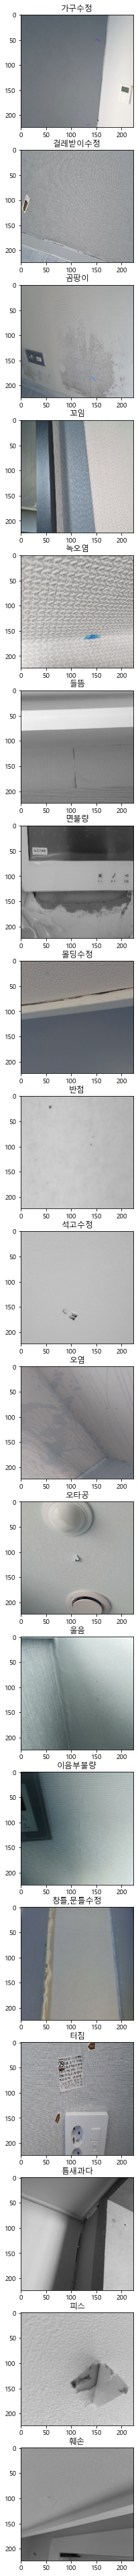

In [20]:
transforms = A.Compose([
    A.ToGray(),
    A.Resize(224,224)
])

aug(transforms)

## Augmentation 실험 - 

In [ ]:
transforms = A.Compose([
    A.ToGray(),
    A.Resize(224,224)
])

aug(transforms)